In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import xarray as xr

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


from delhi_aq.my_nn import SIREN, fit, NeRF, NeRFPE
from delhi_aq.my_utils import pool_image, get_coords_for_image, rmse_fn

import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
seed = 0
config = {"lr": 1e-4, "batch_size": -1, "iterations": 1000}
layers = [2048]*4
activation_scale = 30.0
activation = "gelu"
aq_data = xr.open_dataset("../processed_data/delhi_cpcb_2022_cleaned.nc").to_dataframe().reset_index().set_index("time", drop=False)
aq_data['time'] = aq_data['time'].astype(int)
aq_data = aq_data.dropna(subset="PM2.5")
aq_data.head(2)

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:30:00,"Alipur, Delhi - DPCC",1640997000000000000,2022-01-01 00:00:00,2022-01-01 01:00:00,219.5,342.75,94.73,53.95,105.95,3.78,...,79.75,NaN,205.95,4.6,999.1,6.85,0.0,0.0,28.815329,77.15301
2022-01-01 01:30:00,"Alipur, Delhi - DPCC",1641000600000000000,2022-01-01 01:00:00,2022-01-01 02:00:00,224.5,360.25,89.30,44.70,96.60,5.50,...,82.23,NaN,206.05,4.6,998.9,6.72,0.0,0.0,28.815329,77.15301


In [3]:
x = aq_data[["latitude", "longitude", "time"]].values
y = aq_data[["PM2.5"]].values

train_val_x_, test_x_, train_val_y_, test_y_ = train_test_split(x, y, test_size=0.2, random_state=seed+1)
train_x_, val_x_, train_y_, val_y_ = train_test_split(train_val_x_, train_val_y_, test_size=0.2, random_state=seed+2)

x_scaler = MinMaxScaler((-1, 1))
y_scaler = MinMaxScaler((0, 1))
time_scale = 20
train_x = x_scaler.fit_transform(train_x_)
train_x[:, -1] = train_x[:, -1] * time_scale
val_x = x_scaler.transform(val_x_)
val_x[:, -1] = val_x[:, -1] * time_scale
test_x = x_scaler.transform(test_x_)
test_x[:, -1] = test_x[:, -1] * time_scale
train_y = y_scaler.fit_transform(train_y_)
val_y = y_scaler.transform(val_y_)
test_y = y_scaler.transform(test_y_)
# print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

In [15]:
model = SIREN(n_hidden_layer_neurons=layers, output_shape=train_y_.shape[-1], activation_scale=activation_scale)
# model = NeRF(n_hidden_layer_neurons=layers, output_shape=train_y_.shape[-1], activation=activation)
# model = NeRFPE(n_hidden_layer_neurons=layers, output_shape=train_y_.shape[-1], activation=activation, activation_scale=activation_scale)
params, old_params_history, train_losses, val_losses, test_losses = fit(jax.random.PRNGKey(seed+4), model, 
                                                                        train_x, train_y, config, val_x, val_y, test_x, test_y)

In [16]:
# plt.plot(train_losses, label="train")
# plt.plot(val_losses, label="val")
# plt.plot(test_losses, label="test")
# plt.legend();
best_val_idx = jnp.argmin(val_losses)
print(f"{best_val_idx=}, {val_losses[best_val_idx]=}")
print(f"{train_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=}")
print(f"{test_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=}")
best_params = jtu.tree_map(lambda x: x[best_val_idx], old_params_history)

pred_y = model.apply(best_params, test_x).__array__()
pred_y_ = y_scaler.inverse_transform(pred_y)
# plt.scatter(test_y_, pred_y_)
# plt.plot([0, 500], [0, 500], color="r", linestyle="--");

print(pred_y_.shape, test_y_.shape)
rmse = rmse_fn(test_y_, pred_y_)
r2 = r2_score(test_y_, pred_y_)
rmse, r2

best_val_idx=Array(253, dtype=int32), val_losses[best_val_idx]=Array(0.02638759, dtype=float32)
train_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=Array([10.99267], dtype=float32)
test_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=Array([26.066664], dtype=float32)
(63434, 1) (63434, 1)


(26.066663114296865, 0.9031281547462202)

0.02921045

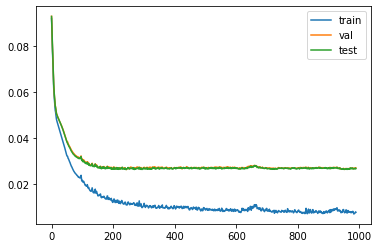

In [17]:
offset = 10
plt.plot(train_losses[offset:], label="train")
plt.plot(val_losses[offset:], label="val")
plt.plot(test_losses[offset:], label="test")
plt.legend();

In [11]:
pred_y_ = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0).fit(train_x_, train_y_.ravel()).predict(test_x_).reshape(-1, 1)
print(pred_y_.shape, test_y_.shape)
rmse = rmse_fn(test_y_, pred_y_)
r2 = r2_score(test_y_, pred_y_)
rmse, r2

(63434, 1) (63434, 1)


(26.04200052689964, 0.9033113757537375)

In [ ]:
plt.scatter(test_y_, pred_y_);
plt.plot([0, 500], [0, 500], color="r", linestyle="--");
plt.xlabel("True")
plt.ylabel("Predicted");

| SIREN | RF |
| --- | --- |
| 28.41 | 26.18 |
| 29.12 | 26.27 |

In [9]:
# Out of memory

# import torch
# from skgpytorch.models import SGPRRegressor
# from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel

# print(train_x.shape, train_y.shape)
# kernel = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[-1])).cuda()
# model = SGPRRegressor(torch.tensor(train_x).cuda(), torch.tensor(train_y).cuda(), kernel, inducing_points=torch.tensor(train_x)[:1000]).cuda()
# model.fit(batch_size=10000, lr=0.1, n_epochs=10, verbose=1, random_state=0)

## Manual plot

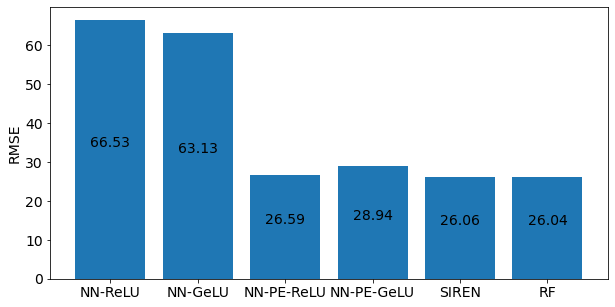

In [5]:
results = {"NN-ReLU": 66.53, "NN-GeLU": 63.13, "NN-PE-ReLU": 26.59, "NN-PE-GeLU": 28.94, "SIREN": 26.06, "RF": 26.04}

plt.figure(figsize=(10, 5))
plt.rcParams["font.size"] = 14
plt.bar(results.keys(), results.values());
for k, v in results.items():
    plt.text(k, v/2, f"{v:.2f}", ha="center", va="bottom")
    
plt.ylabel("RMSE");

Try extrapolation

In [6]:
picked_station = aq_data["station"].unique()[0]
time_series = aq_data[aq_data["station"] == picked_station][["time", "PM2.5"]]
time_series["time"] = time_series["time"]/1e18
time_series

,time,PM2.5
time,,
2022-01-01 00:30:00,1.640997,219.50
2022-01-01 01:30:00,1.641001,224.50
2022-01-01 02:30:00,1.641004,217.00
2022-01-01 03:30:00,1.641008,214.25
2022-01-01 04:30:00,1.641011,207.50
...,...,...
2023-01-01 17:30:00,1.672594,74.00
2023-01-01 18:30:00,1.672598,80.00
2023-01-01 19:30:00,1.672601,132.00
